# Database Initialization

In [330]:
from __future__ import division
db = 'twitterGender'
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
myDB = URL(drivername='mysql', database=db, query={ 'read_default_file' : '/home/fatal/.my.cnf' })
engine = create_engine(name_or_url=myDB, encoding='utf8')
#conn = engine.connect()


# Necessary Libraries & Global Variables

In [286]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as ss
import pandas as pd
import warnings

import time
import pdb

SMALL_VAL = 0.0000001


# Find Best Fit Distribution
## Function name: best_fit_distribution
**Args:**
* data -> a series of data values (like group norms in our case)
* bins -> how many bins we want to divide the data into (default = 200)
* ax -> axes subplots (default None)
  * subplot of the data with x and y limits set
  * If given, this function will add histogram of data + all different distribution lines to this subplot

**Returns:**
* Best_Distribution_name -> winner among all distributions
* Best_SSE -> Minimum sum of squared error
* Best_params -> parameters of the best distribution which has at least two parameters of "Location" and "Scale" + any additional parameters based on the distribution type

**What it does?**
* Creates a histogram of the data divided to <BINS> bins
* Sets x as the center of each bin
* Sets y as the frequency value of each bin (normed = True)
* Finds the best fit distribution among previously defined distributions based on the SSE of the returned value and the actual value
  * Uses scipy.stats distribution methods **fit** and **pdf**
  * scipy.stats current Distributions are **norm**, **expon**, and **lognorm** for now
* If ax is set, it adds histogram and all the distributions lines with their MLE parameters to that

In [363]:
# Create models from data
def best_fit_distribution(data, ax=None):
    """Model data by finding best fit distribution to data"""
    DISTRIBUTIONS = [
        ss.norm, ss.expon, ss.lognorm
    ]
    # Best holders
    best_distribution = ss.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # pdb.set_trace()
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                #s3 = time.time()
                if distribution.name == 'lognorm':
                    logdata = np.log(data)
                    estimated_mu, estimated_sigma = ss.norm.fit(logdata)
                    params = [estimated_sigma, 0, np.exp(estimated_mu)]
                    #params1 = distribution.fit(data, floc=0)
                else:
                    params = distribution.fit(data)
                    
                #s4 = time.time()
                #print(distribution.name + ':' + str(round(s4-s3)))

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                statistics, pval = ss.kstest(data, distribution.name, args=params)
                #sse = np.sum(np.power(y - pdf, 2.0))
                # if axis pass in add to plot
                try:
                    if ax:
                        #num_bins = 2000
                        #counts, bin_edges = np.histogram(data, bins=num_bins)
                        #pdb.set_trace()
                        #bin_edges = (bin_edges + np.roll(bin_edges, -1))[:-1]/2.0
                        #np.cumsum(counts), bin_edges[:-1]
                        # Calculate fitted PDF and error with fit in distribution
                        cdf = distribution.cdf(data, loc=loc, scale=scale, *arg)
                        pd.Series(cdf, data). \
                        plot(ax=ax, label=distribution.name + str(round(statistics, 4)))
                    end
                except Exception:
                    pass
                # identify if this distribution is better
                if best_sse > statistics > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = statistics

        except Exception:
            print(Exception.message)
            pass
    return (best_distribution.name, best_sse, best_params)

In [375]:
# Create models from data
def best_anderson_fit_distribution(data, ax=None):
    """Model data by finding best fit distribution to data"""
    DISTRIBUTIONS = [
        ss.norm, ss.expon, ss.lognorm
    ]
    # Best holders
    best_distribution = ss.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # pdb.set_trace()
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                #s3 = time.time()
                #pdb.set_trace()
                if distribution.name == 'lognorm':
                    logdata = np.log(data)
                    statistics, critical_values, significance_level = ss.anderson(logdata, 'norm')
                else:
                    statistics, critical_values, significance_level = ss.anderson(data, distribution.name)
                    
                #s4 = time.time()              
                # if axis pass in add to plot
                try:
                    if ax:
                        #num_bins = 2000
                        #counts, bin_edges = np.histogram(data, bins=num_bins)
                        #pdb.set_trace()
                        #bin_edges = (bin_edges + np.roll(bin_edges, -1))[:-1]/2.0
                        #np.cumsum(counts), bin_edges[:-1]
                        # Calculate fitted PDF and error with fit in distribution
                        if distribution.name == 'lognorm':
                            logdata = np.log(data)
                            estimated_mu, estimated_sigma = ss.norm.fit(logdata)
                            params = [estimated_sigma, 0, np.exp(estimated_mu)]
                            #params1 = distribution.fit(data, floc=0)
                        else:
                            params = distribution.fit(data)
                        arg = params[:-2]
                        loc = params[-2]
                        scale = params[-1]
                        cdf = distribution.cdf(data, loc=loc, scale=scale, *arg)
                        pd.Series(cdf, data). \
                        plot(ax=ax, label=distribution.name + str(round(statistics, 4)))
                    end
                except Exception:
                    pass
                # identify if this distribution is better
                if best_sse > statistics > 0:
                    best_distribution = distribution
                    best_params = 'params'
                    best_sse = statistics

        except Exception:
            print(Exception.message)
            pass
    return (best_distribution.name, best_sse, best_params)

# Distribution of best fit distributions among all different features

 Gives you count of features in each distribution
 And also best fitted distribution to each feature


In [368]:
def prepare_data(raw_df, include_zero=True):
    data = raw_df.group_norm.tolist()
    nonExisting_cnt = max(0, int(group_cnt - len(data)))
    # Appending zero for those that does not use this feature at all
    # By removing this line you can find the best 
    if include_zero:
        data = data + ([SMALL_VAL]*nonExisting_cnt)
    return data

def find_best_fit_for_all_feats(table_name, include_zero=True, useAnderson=False):
    # Load DATA from DB
    stime = time.time()
    group_cnt = pd.read_sql('select count(distinct group_id) cnt from ' + table_name, con=engine)
    group_cnt = group_cnt.cnt
    # Load distinct features
    features = pd.read_sql('select distinct feat from ' + table_name, con=engine)
    feat_cnt = len(features)
    print(str(feat_cnt) + ' unique features' )
    DISTRIBUTIONS = [
        ss.norm, ss.expon, ss.lognorm
    ]
    pval_threshold = 0.05
    cntr = 1
    usr_best_fit = []
    query_time = 0
    fit_time = 0

    # Load data feature by feature and find the best distribution for each feature
    for index, eachfeat in features.iterrows():
        feat = eachfeat.feat
        feat = feat.replace("'", "''").replace("%", "%%").replace('\\', '\\\\')
        qs = time.time()
        raw_df = pd.read_sql("select * from " + table_name + " where feat = '" + feat + "'", con=engine)
        qe = time.time()
        data = prepare_data(raw_df, include_zero)
        if useAnderson:
            best_fit_name, best_sse, best_fit_paramms = best_anderson_fit_distribution(data)
        else:    
            best_fit_name, best_sse, best_fit_paramms = best_fit_distribution(data)
        usr_best_fit.append([feat, len(raw_df), best_fit_name, best_sse, best_fit_paramms])
        beste = time.time()
        query_time += (qe-qs)
        fit_time += (beste-qe)
        x = str(cntr) + ' out of ' + str(feat_cnt) + ', ' + feat + '-> query exec: ' \
        + str(round(qe-qs)) + 's, fit & plot: ' + str(round(beste-qe)) + 's'
        print '\r', x, 
        #print x
        cntr += 1
    etime = time.time()
    print
    print('overall time: ' + str(round(etime-stime)) + 's -> query exec: ' + str(round(query_time)) + \
          's , fit & plot: ' + str(round(fit_time)) + 's') 
    df = pd.DataFrame(usr_best_fit, columns=['feat', 'count', 'best_fitted', 'best_statistic', 'best_params'])
    feat_dist = df.groupby('best_fitted').feat.count()
    print(feat_dist)

    df = df.sort_values('best_statistic')
    return df

# Draw Two plots for the data
One including all tested distributions and the other the best fitted one

**Args:**
* table_name -> to fetch data from
* feature -> specific feature that we want to fetch data for

**What it does?**
draws two plots for this data
* First one contains all the distributions over the histogram of the data with their MLE parameters.
For this we call function best_fit_distribution with a previously initiated subplot ax with the data ranges.
* Second one contains the winner, the fitted distribution with minimum SSE among all.
For this we generate a pdf out of 10000 samples using the parameters of the winning distribution and draw it.

In [369]:
def draw_plots(table_name, feature, useAnderson=False):
    """Draw plot including real data cdf and also all distributions' cdfs"""
    title = feature
    raw_df = pd.read_sql("select * from " + table_name + " where feat = '" + feature + "'", con=engine)
    data = prepare_data(raw_df)
    plt.figure(figsize=(12,8))
    sorted_data = np.sort(data)
    N = len(sorted_data)
    frequencies = np.arange(1, N+1)/N
    plt.plot(sorted_data, frequencies, color='black', linewidth='3')
    ax=plt.subplot(111)
    #ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
    # Save plot limits
    dataYLim = ax.get_ylim()
    
    # Find best fit distribution
    if useAnderson:
        best_fit_name, best_sse, best_fit_paramms = best_anderson_fit_distribution(sorted_data, ax)
    else:
        best_fit_name, best_sse, best_fit_paramms = best_fit_distribution(sorted_data, ax)
    ax.legend(loc='upper right')
    best_dist = getattr(ss, best_fit_name)

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(str(title) + ',' + best_fit_name + '\n All Fitted Distributions')
    ax.set_xlabel('Group Norm')
    ax.set_ylabel('Frequency')
    return (best_fit_name, best_sse, best_fit_paramms)


# LIWC User Level

64 unique features
64 out of 64, YOU-> query exec: 0.0s, fit & plot: 0.0s
overall time: 3.0s -> query exec: 1.0s , fit & plot: 2.0s
best_fitted
expon      10
lognorm     3
norm       51
Name: feat, dtype: int64

 4 Best Fitted Distributions

 4 Worst Fitted Distributions


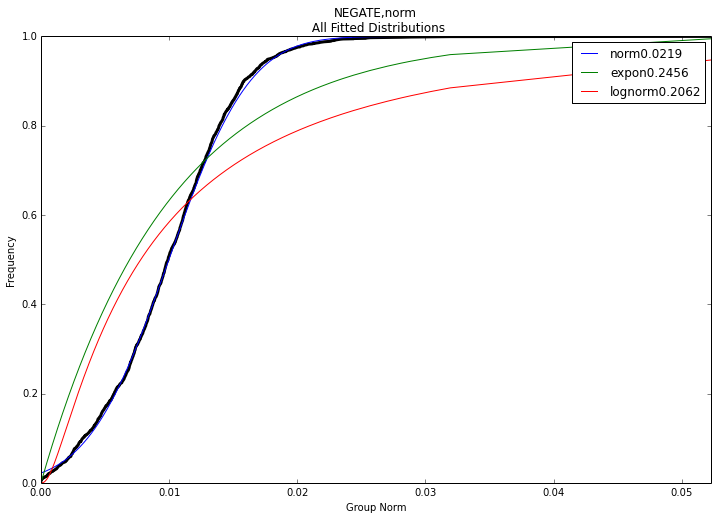

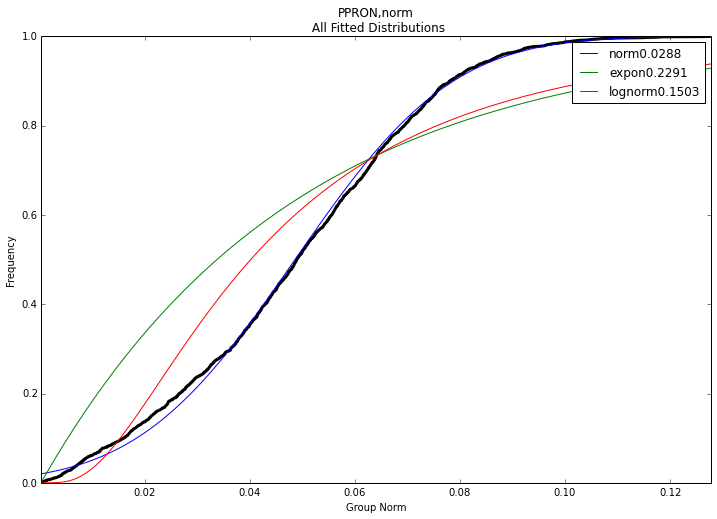

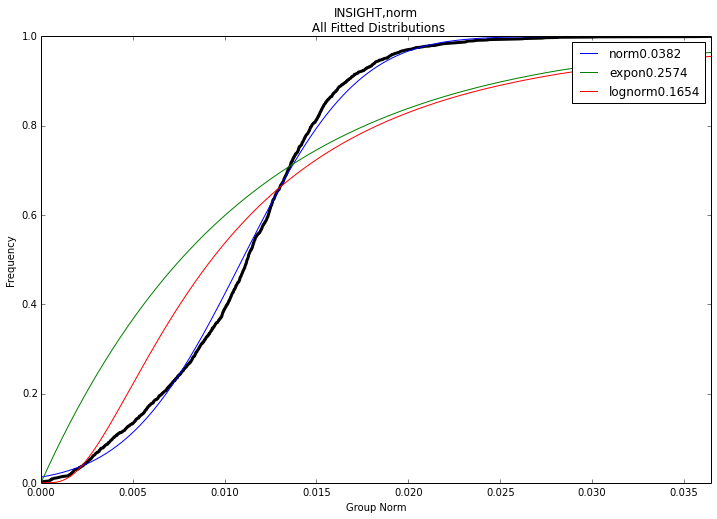

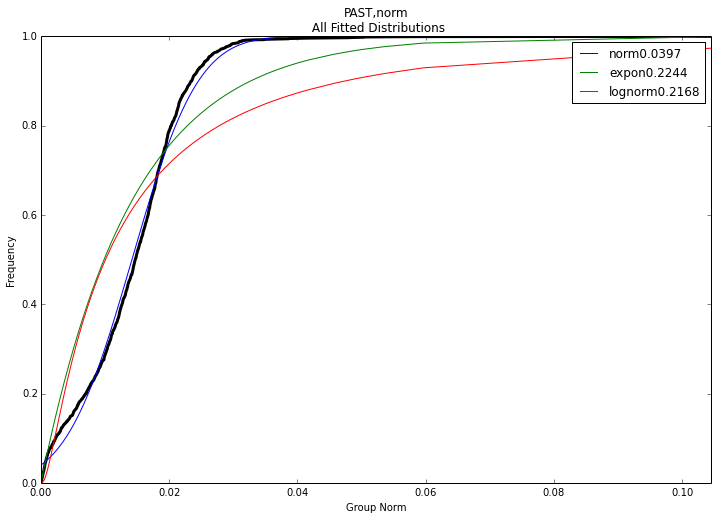

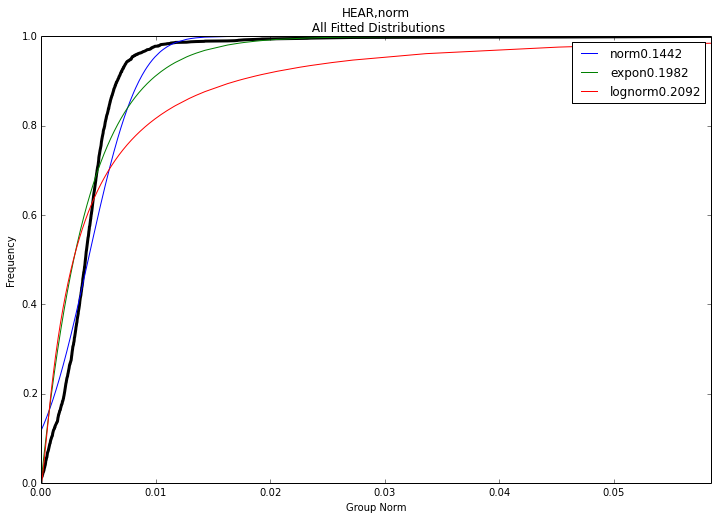

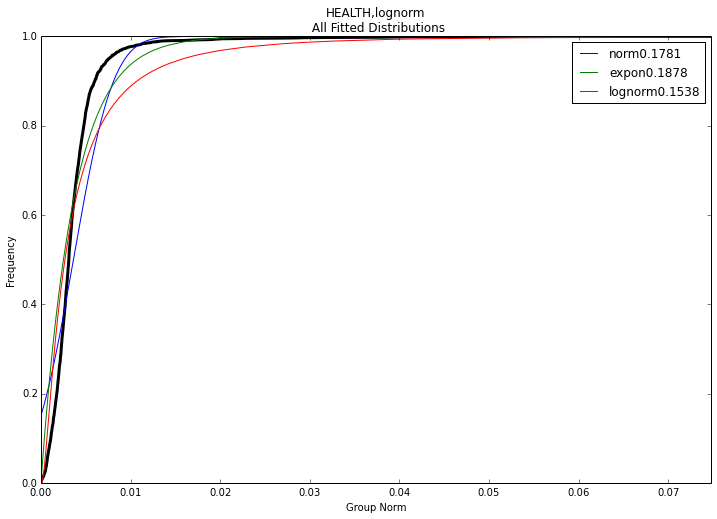

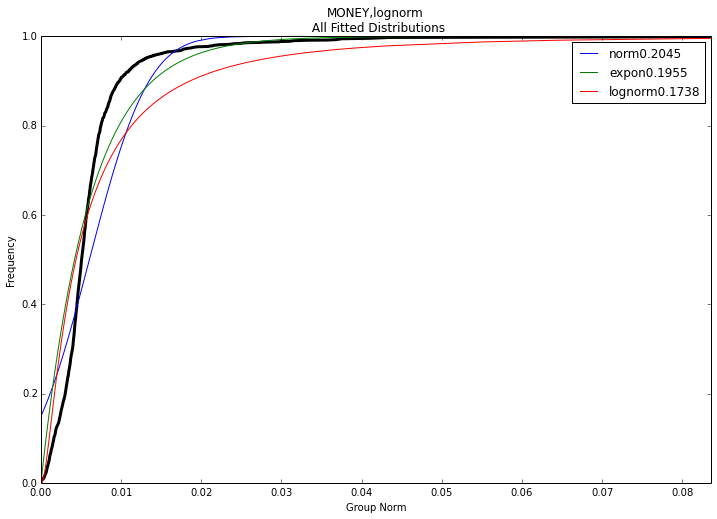

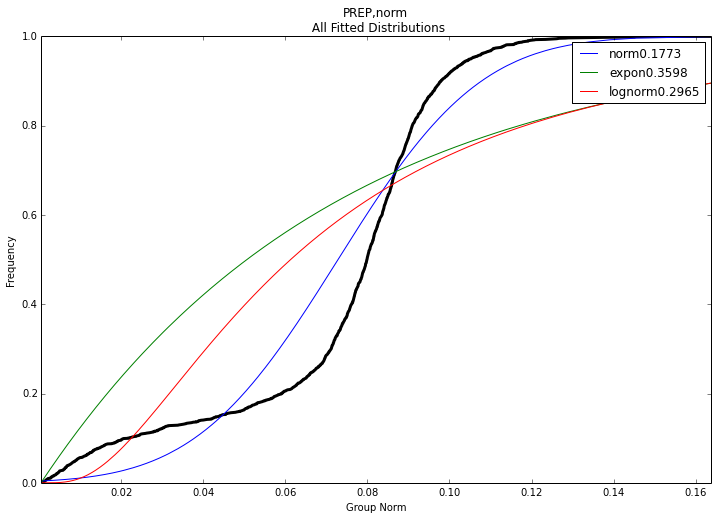

In [362]:
table_name = 'feat$cat_LIWC2007$msgs_r2k$user_id$16to16'
df_userliwc = find_best_fit_for_all_feats(table_name)
print('\n 4 Best Fitted Distributions')
for idx, eachRow in df_userliwc.head(4).iterrows():
    draw_plots(table_name, str(eachRow.feat))
print('\n 4 Worst Fitted Distributions')
for idx, eachRow in df_userliwc.tail(4).iterrows():
    draw_plots(table_name, str(eachRow.feat))

64 unique features
64 out of 64, YOU-> query exec: 0.0s, fit & plot: 0.0s
overall time: 1.0s -> query exec: 1.0s , fit & plot: 0.0s
best_fitted
expon      24
lognorm    10
norm       30
Name: feat, dtype: int64

 4 Best Fitted Distributions

 4 Worst Fitted Distributions


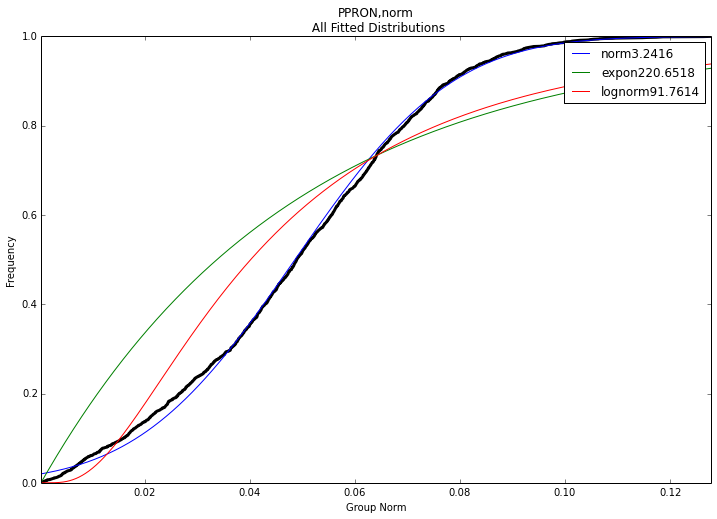

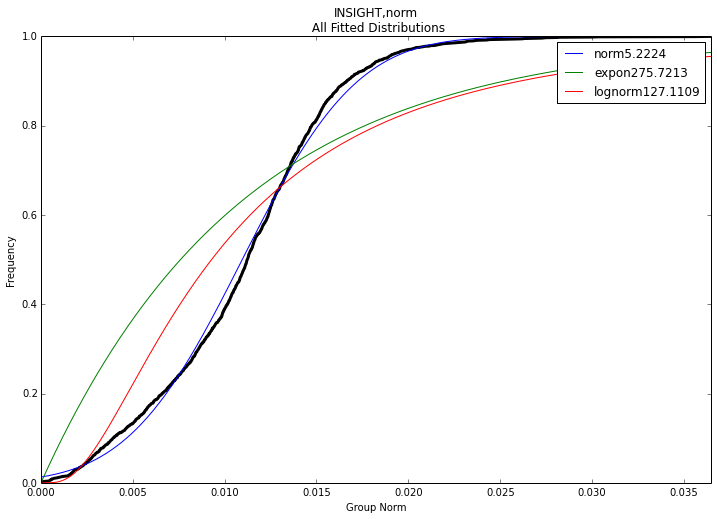

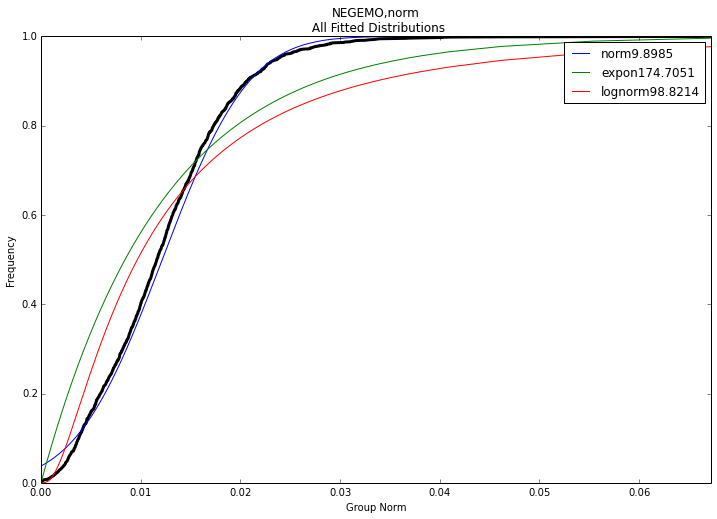

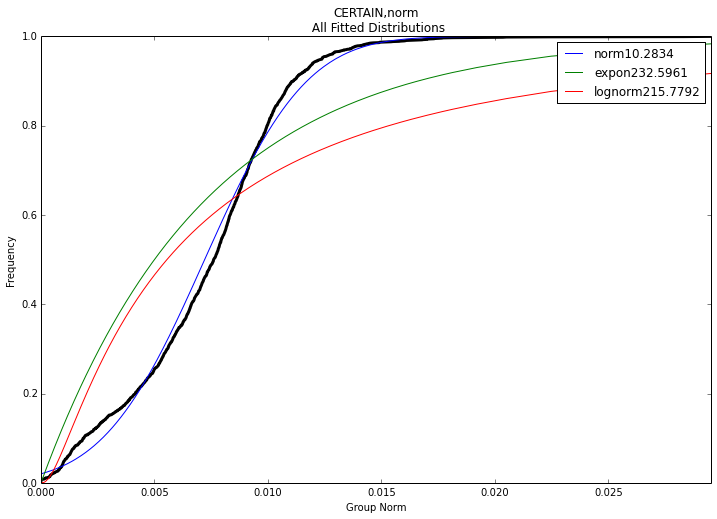

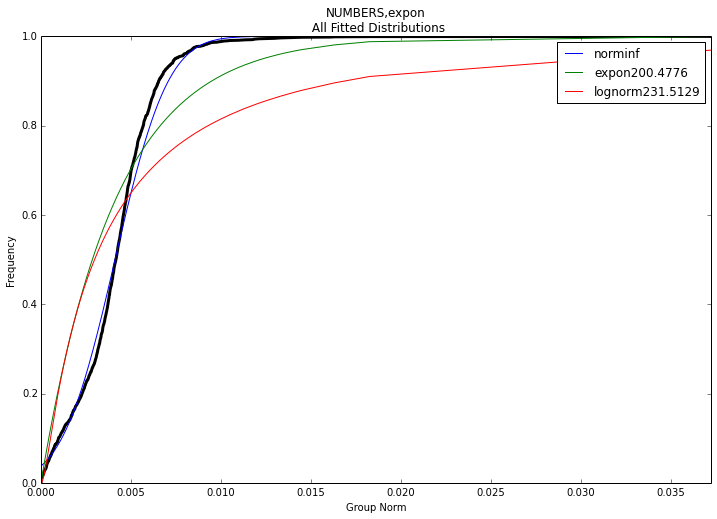

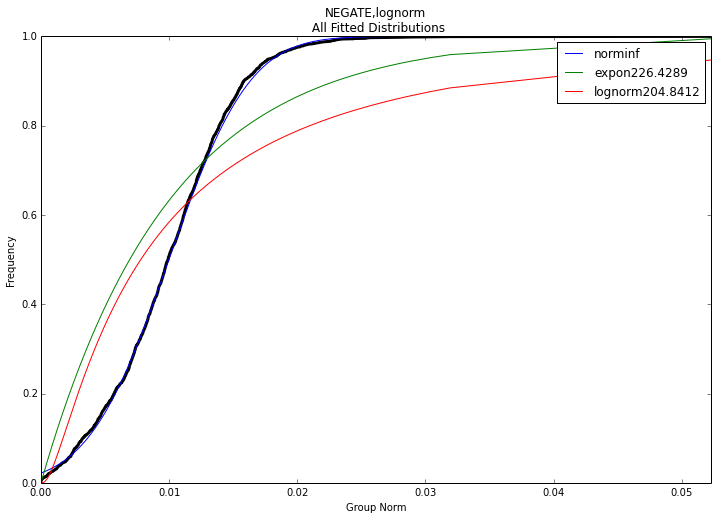

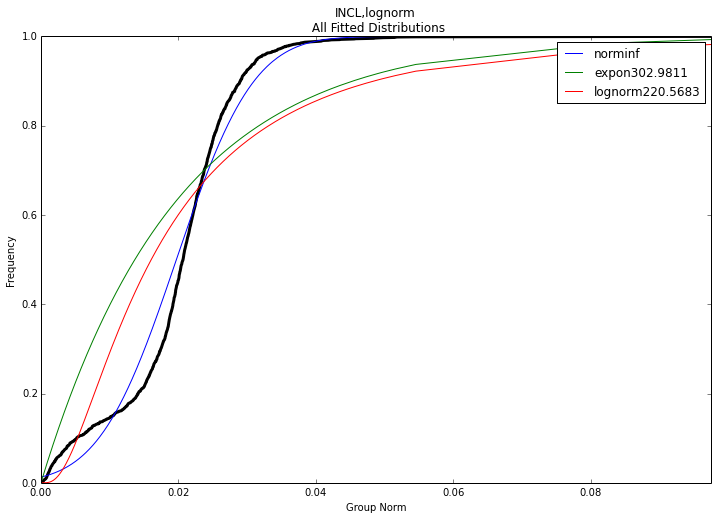

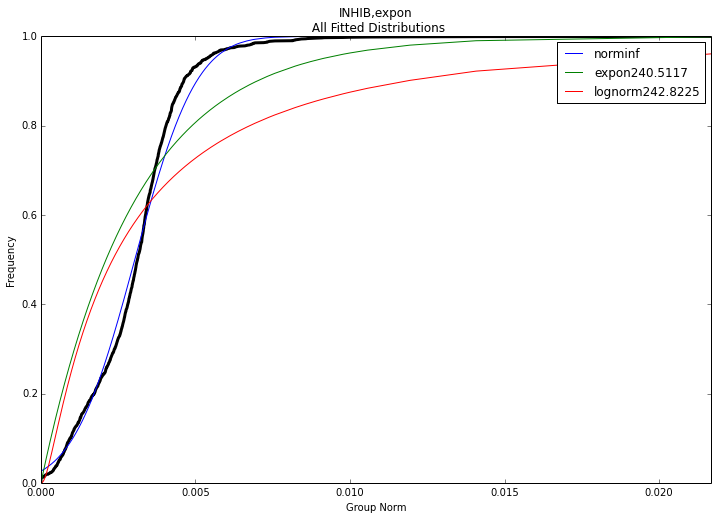

In [376]:
table_name = 'feat$cat_LIWC2007$msgs_r2k$user_id$16to16'
df_userliwc_anderson = find_best_fit_for_all_feats(table_name, useAnderson=True)
print('\n 4 Best Fitted Distributions')
for idx, eachRow in df_userliwc_anderson.head(4).iterrows():
    draw_plots(table_name, str(eachRow.feat), useAnderson=True)
print('\n 4 Worst Fitted Distributions')
for idx, eachRow in df_userliwc_anderson.tail(4).iterrows():
    draw_plots(table_name, str(eachRow.feat), useAnderson=True)

0.999999999
0.990281816505
mean: 0.009980633669
std: 0.00495040601573
[ 3.10244631  3.11120049  3.13534561  3.17376597  3.44343339  3.6614754
  3.81090361  4.13627065  4.43441192]
[ 0.99904036  0.99906836  0.99914174  0.99924763  0.99971281  0.99987462
  0.99993077  0.99998235  0.99999538]
[  4.81463649e-04   1.44439095e-03   2.40731825e-03 ...,   1.99759268e+00
   1.99855561e+00   1.99951854e+00]
[        -inf -16.10745682 -14.76630426 ...,  -0.02215544  -0.02214241
  -0.02213779]


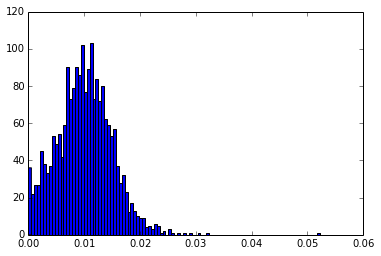

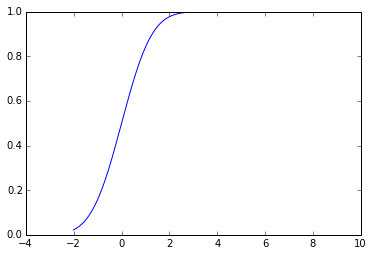

In [445]:
print(0.999999999)
d = ss.norm.rvs(size=100)
dcdf=ss.norm.cdf(np.sort(d))
print(dcdf[-1])
raw_df = pd.read_sql("select * from feat$cat_LIWC2007$msgs_r2k$user_id$16to16 where feat = 'NEGATE'", con=engine)
x = prepare_data(raw_df, True)
plt.hist(x, bins=100)
y = np.sort(x)
N=len(y)
xbar = np.mean(x, axis=0)
print('mean: '+str(xbar))
s = np.std(x, ddof=1, axis=0)
print('std: ' + str(s))
w = (y - xbar) / s
z = ss.norm.cdf(w)
plt.figure()
plt.plot(w, z)
i = np.arange(1, N + 1)
A2 = -N - np.sum((2*i - 1.0) / N * (np.log(z) + np.log(1 - z[::-1])), axis=0)
print(w[-10:-1])
print(z[-10:-1])
print((2*i - 1.0) / N )
print((np.log(z) + np.log(1 - z[::-1])))



# Topics User Level

2000 unique features
2000 out of 2000, 999-> query exec: 0.0s, fit & plot: 0.0s
overall time: 130.0s -> query exec: 57.0s , fit & plot: 68.0s
best_fitted
expon      857
lognorm    644
norm       499
Name: feat, dtype: int64

 4 Best Fitted Distributions

 4 Worst Fitted Distributions


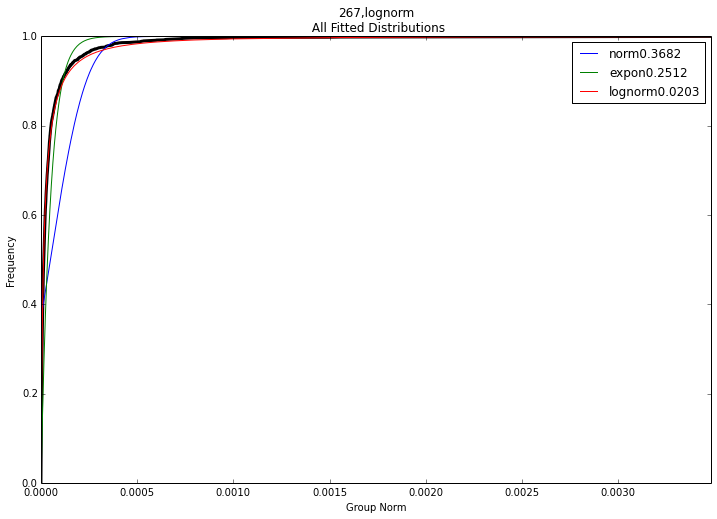

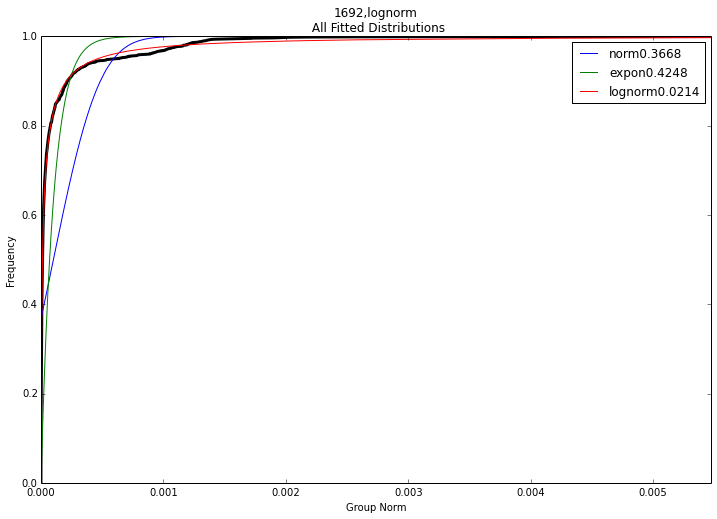

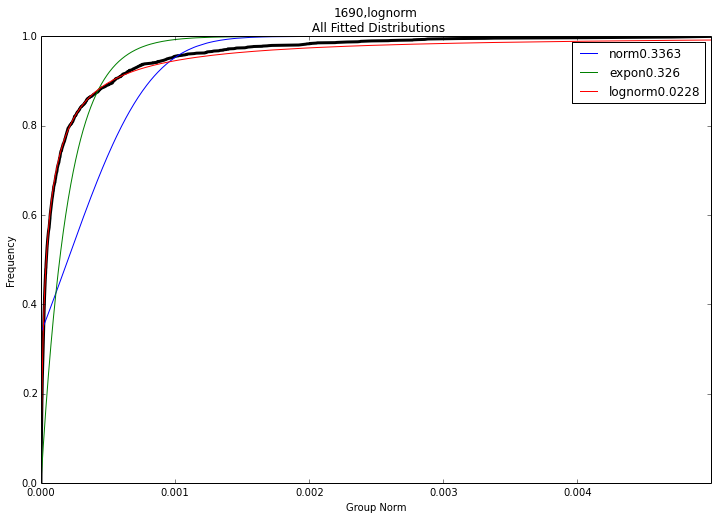

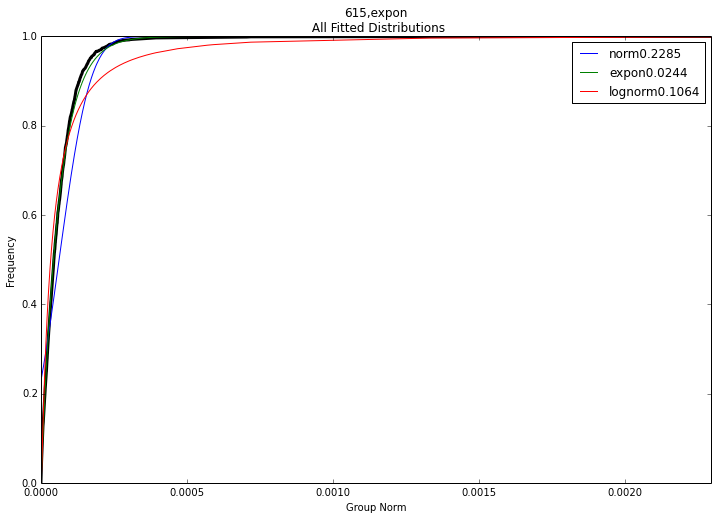

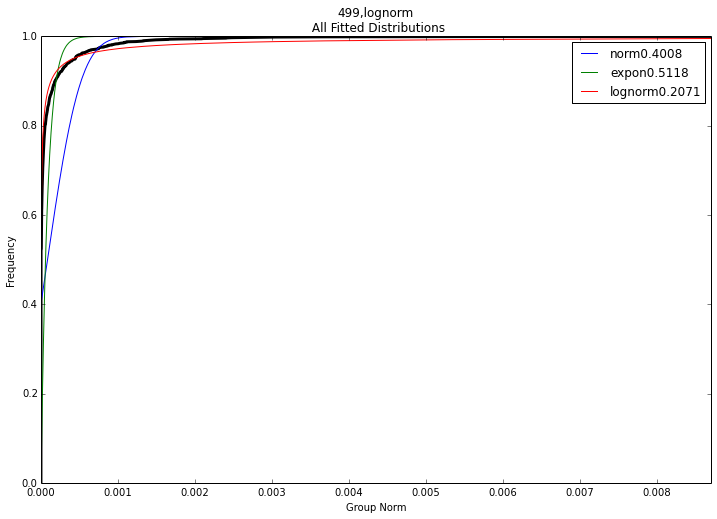

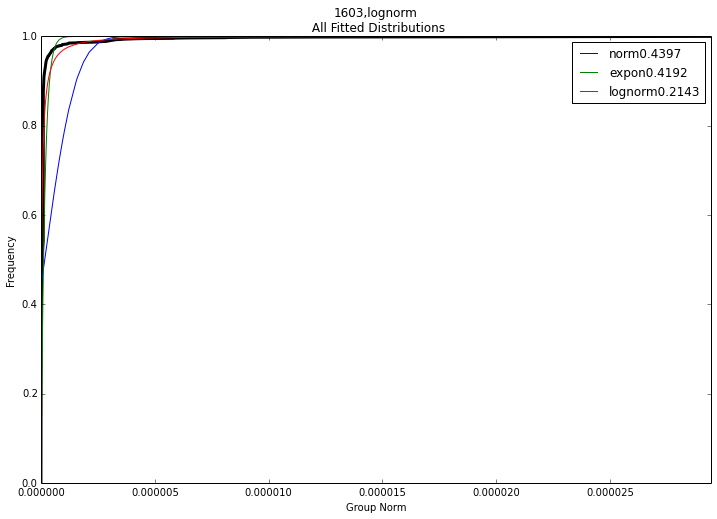

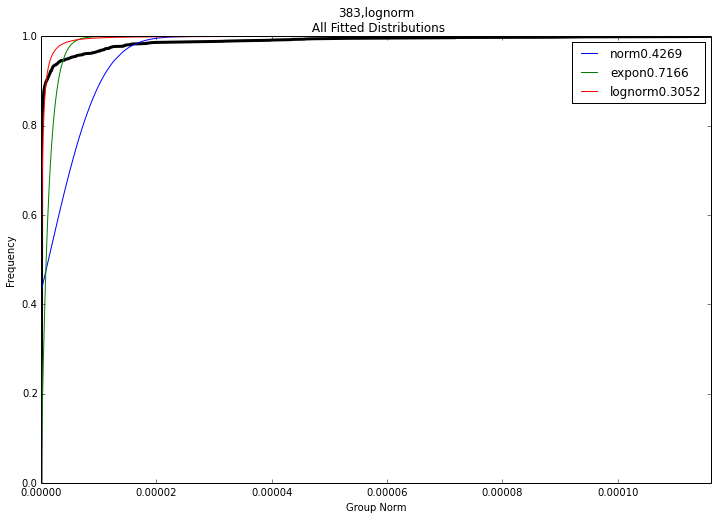

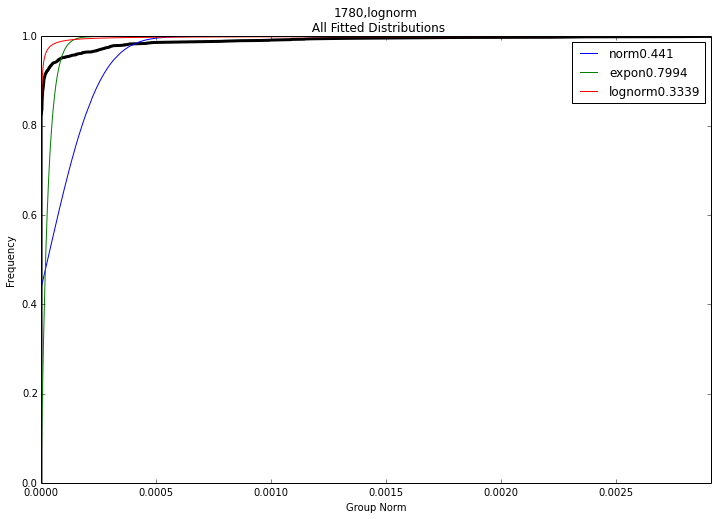

In [342]:
table_name = 'feat$cat_met_a30_2000_cp_w$msgs_r2k$user_id$16to16'
df_usertopic = find_best_fit_for_all_feats(table_name)
print('\n 4 Best Fitted Distributions')
for idx, eachRow in df_usertopic.head(4).iterrows():
    draw_plots(table_name, str(eachRow.feat))
print('\n 4 Worst Fitted Distributions')
for idx, eachRow in df_usertopic.tail(4).iterrows():
    draw_plots(table_name, str(eachRow.feat))

 2000 unique features
2000 out of 2000, 999-> query exec: 0.0s, fit & plot: 0.0s
overall time: 58.0s -> query exec: 46.0s , fit & plot: 10.0s
best_fitted
expon      961
lognorm    996
norm        43
Name: feat, dtype: int64

 4 Best Fitted Distributions

 4 Worst Fitted Distributions


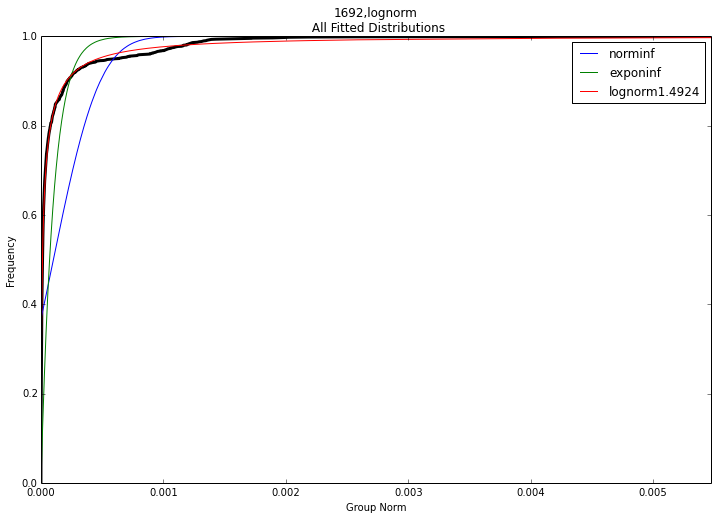

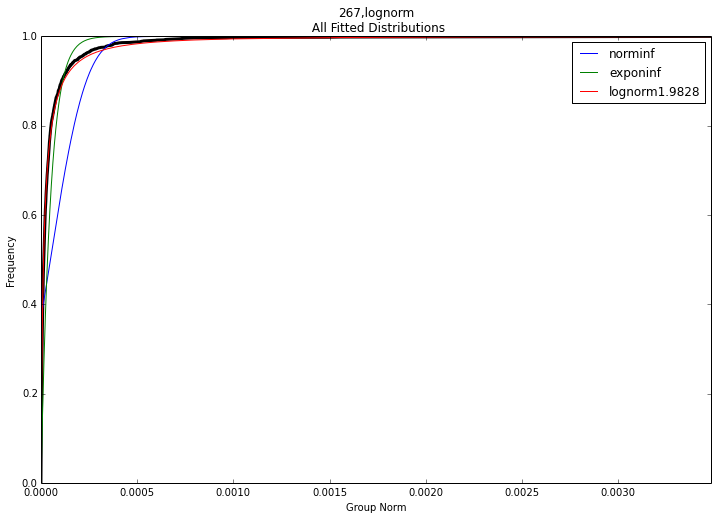

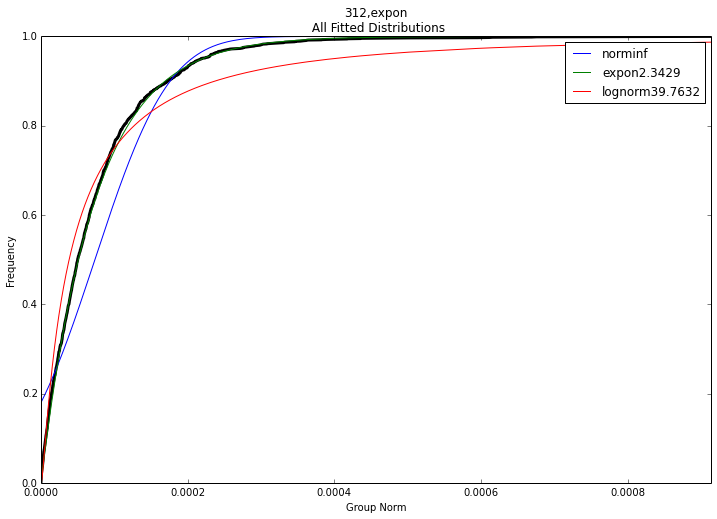

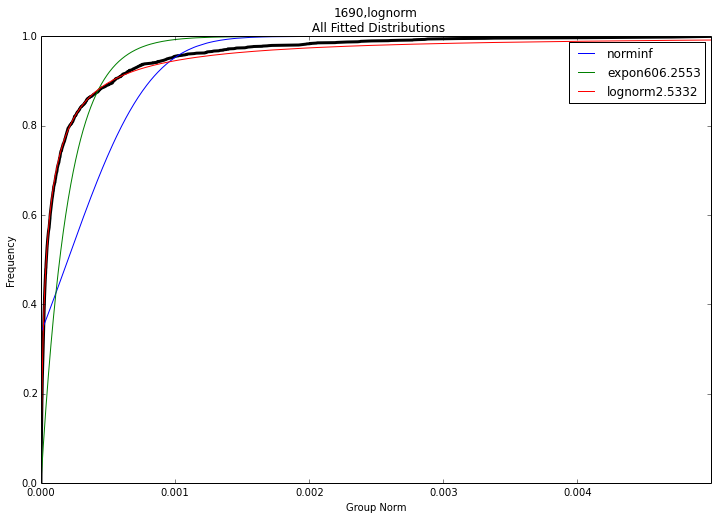

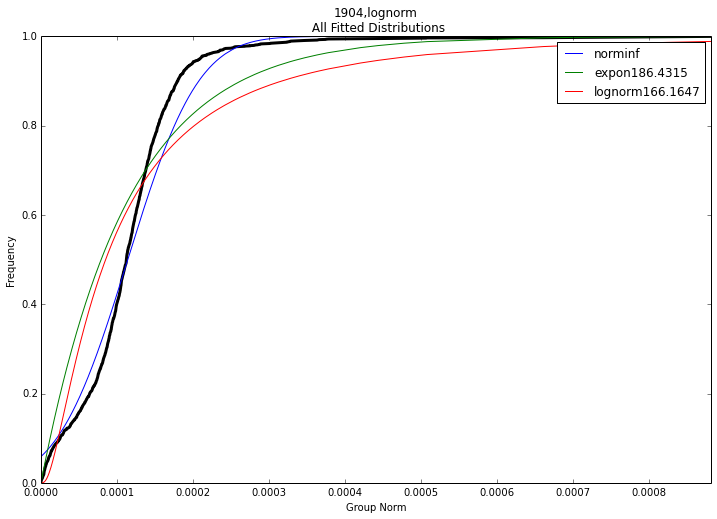

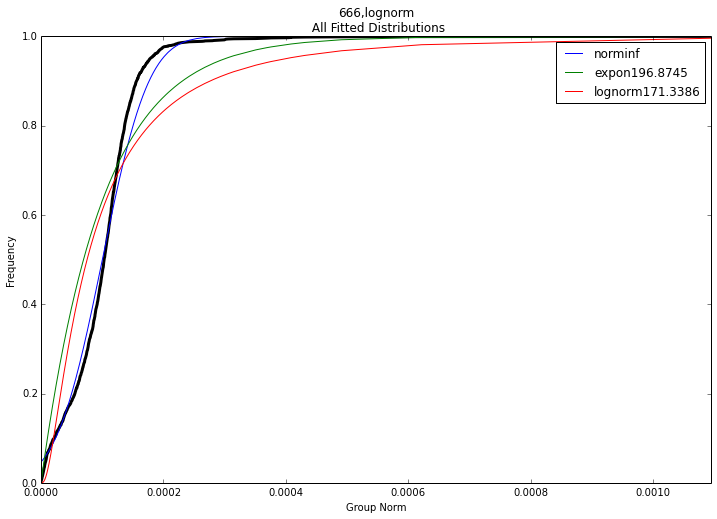

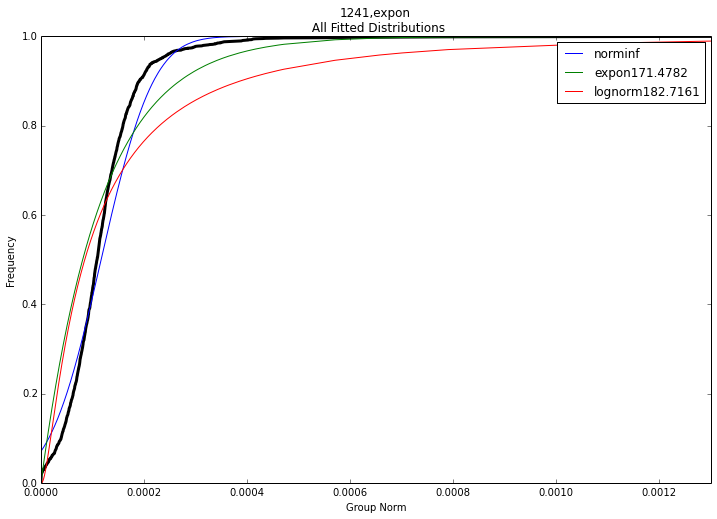

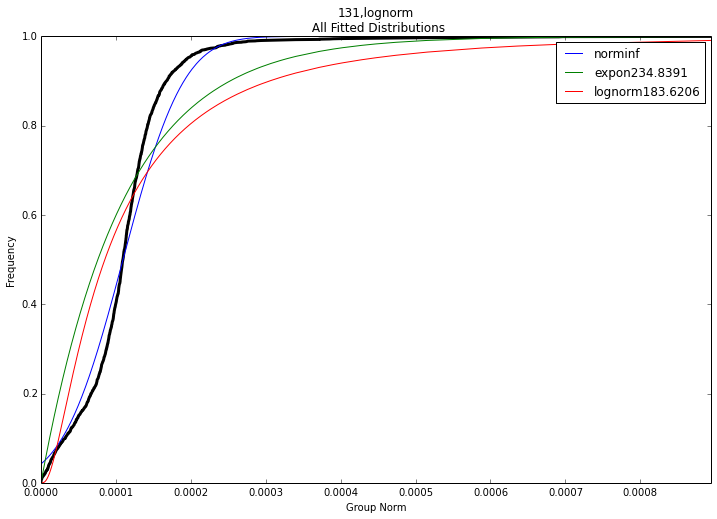

In [379]:
table_name = 'feat$cat_met_a30_2000_cp_w$msgs_r2k$user_id$16to16'
df_usertopic_anderson = find_best_fit_for_all_feats(table_name, useAnderson=True)
print('\n 4 Best Fitted Distributions')
for idx, eachRow in df_usertopic_anderson.head(4).iterrows():
    draw_plots(table_name, str(eachRow.feat), useAnderson=True)
print('\n 4 Worst Fitted Distributions')
for idx, eachRow in df_usertopic_anderson.tail(4).iterrows():
    draw_plots(table_name, str(eachRow.feat), useAnderson=True)

# 1grams User Level

57739 unique features
57739 out of 57739, �-> query exec: 0.0s, fit & plot: 0.0s
overal time: 2214.0s -> query exec: 243.0s , fit & plot: 1931.0s
best_fitted
expon        345
lognorm     1286
norm       56108
Name: feat, dtype: int64

 4 Best Fitted Distributions

 4 Worst Fitted Distributions


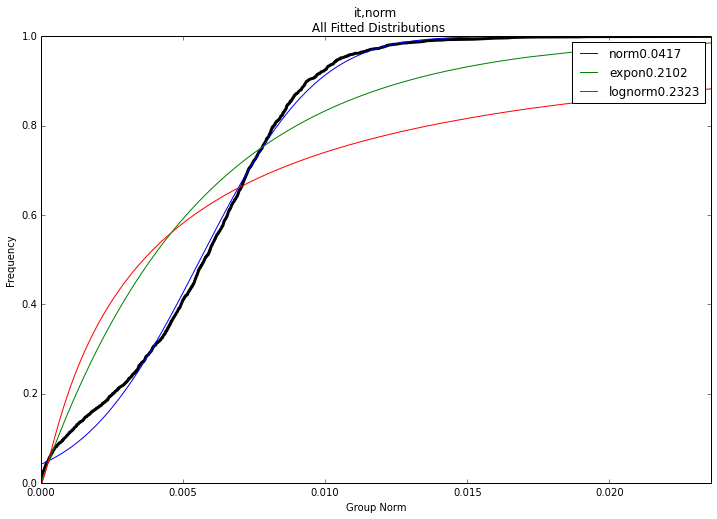

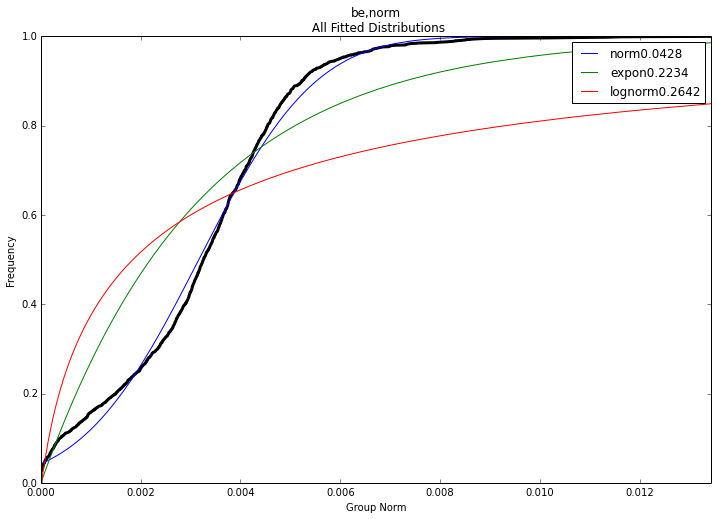

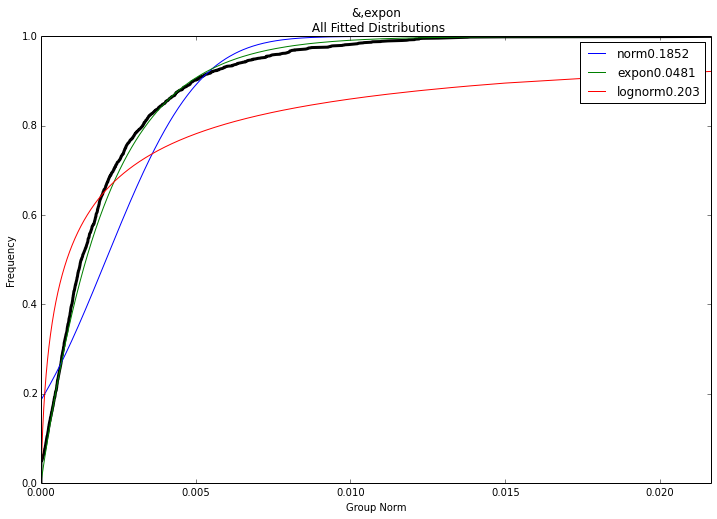

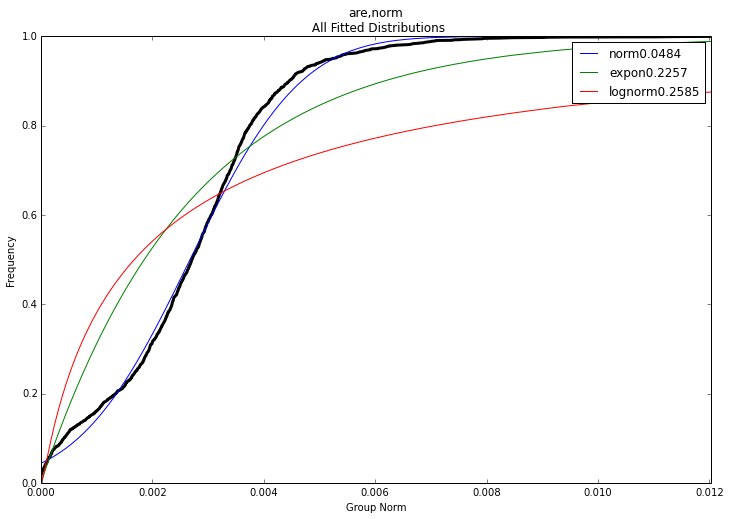

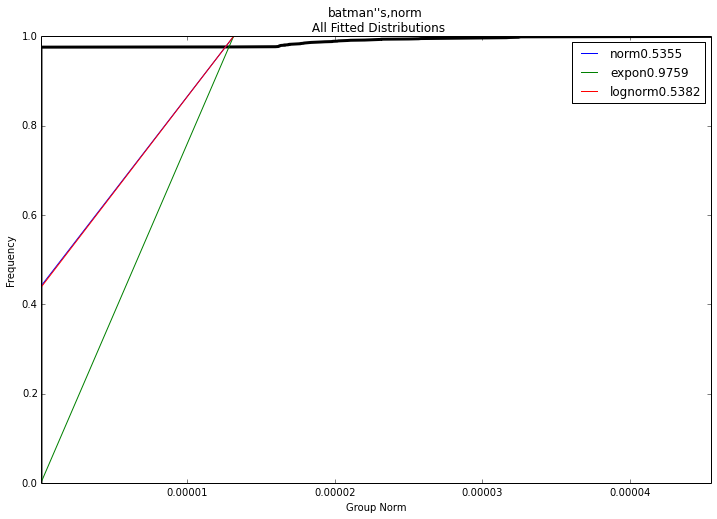

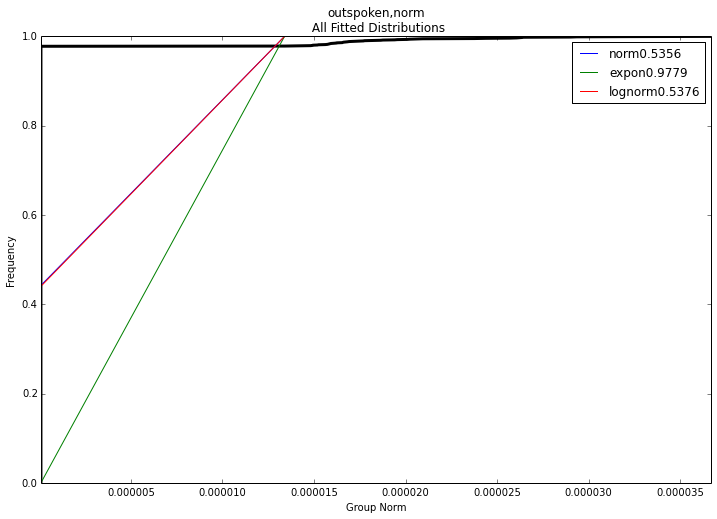

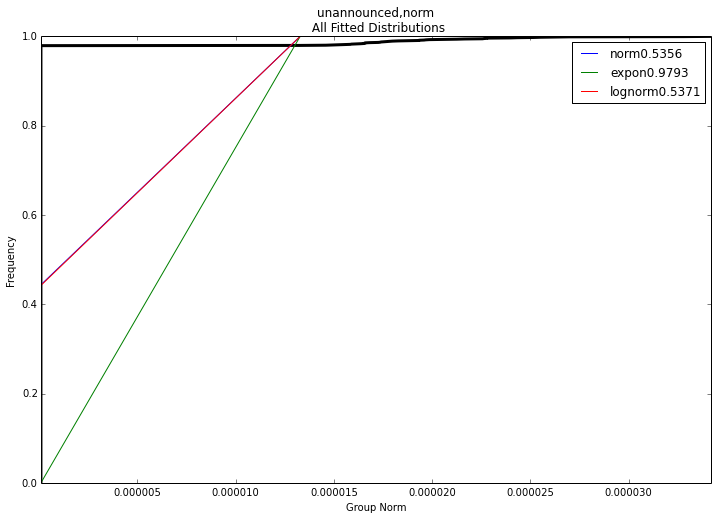

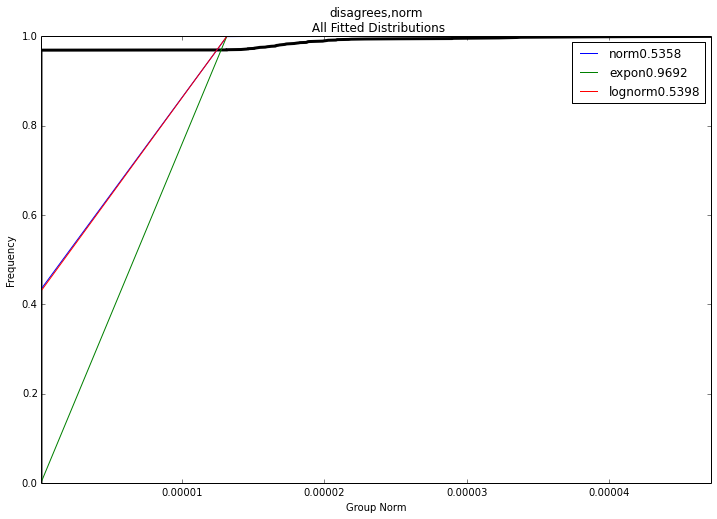

In [333]:
table_name = 'feat$1gram$msgs_r2k$user_id$16to16$0_01'
df_user1gram = find_best_fit_for_all_feats(table_name)
print('\n 4 Best Fitted Distributions')
for idx, eachRow in df_user1gram.head(4).iterrows():
    draw_plots(table_name, str(eachRow.feat))print('\n 4 Worst Fitted Distributions')
for idx, eachRow in df_user1gram.tail(4).iterrows():
    draw_plots(table_name, str(eachRow.feat))

In [361]:
print('**************USER LIWC***************')
print(df_userliwc.head(100).drop(['best_params'], axis=1))
print('**************USER Topic***************')
print(df_usertopic.head(100).drop(['best_params'], axis=1))
print('**************USER 1Gram***************')
print(df_user1gram.head(100).drop(['best_params'], axis=1))

**************USER LIWC***************
       feat  count best_fitted  best_statistic
36   NEGATE   2063        norm        0.021869
43    PPRON   2077        norm        0.028835
31  INSIGHT   2073        norm        0.038162
40     PAST   2072        norm        0.039659
37   NEGEMO   2070        norm        0.041332
46  PRONOUN   2077        norm        0.045178
11  CERTAIN   2061        norm        0.048255
26   HUMANS   2054        norm        0.048689
16     EXCL   2071        norm        0.048719
57   TENTAT   2073        norm        0.050575
27        I   2075        norm        0.051814
22   FUTURE   2048        norm        0.053121
15  DISCREP   2063        norm        0.053650
42   POSEMO   2075        norm        0.056247
39  NUMBERS   2055        norm        0.056569
63      YOU   2067        norm        0.057679
13     CONJ   2076        norm        0.059495
18     FEEL   2053        norm        0.059924
1   ADVERBS   2076        norm        0.062608
10    CAUSE   2071   